# Do Whales Move the Market? – USDC Case Study

This mini‑capstone project investigates whether large transfers of USD Coin (USDC) – often referred to as **whale transactions** – precede or correlate with significant price movements. We combine on‑chain transaction data from **Sim by Dune** with market price data from the **CoinGecko API**. Using Python libraries such as `pandas` and `matplotlib`, we'll wrangle the data, perform time‑series analysis, visualize the relationship between whale activity and price behaviour and draw insights.

We'll tackle the problem step by step. Each question below corresponds to a distinct analysis task, accompanied by its own markdown explanation and code cell.


## Question 1: Import required libraries

Before we start exploring data, we need to import the Python packages we'll use.  
We rely on:

* **pandas** for data manipulation and analysis.
* **matplotlib.pyplot** and **seaborn** for charting.
* **json** to parse the saved API responses.
* **datetime** for working with time values.

The seaborn darkgrid style is set to make plots more readable.


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.1)

print('Libraries imported successfully')


Libraries imported successfully


## Question 2: Download and prepare price data (CoinGecko)

To examine whether large transfers coincide with notable price movements we need a historical record of **USDC** prices.  

> **Network restrictions:** The notebook environment cannot make external HTTP requests.  
> To work around this limitation, the price history for USDC (last 90 days) was downloaded using the public CoinGecko API outside of the notebook and saved to `/home/oai/share/usdc_price.json`. The JSON contains an array called `prices`, where each element is `[timestamp, price]` with the timestamp in milliseconds since the Unix epoch.

In the code below we load the JSON file, convert it into a DataFrame, parse the timestamps into timezone‑aware datetimes (Africa/Lagos), and preview the result.


In [2]:
# Load pre-downloaded USDC price history
price_file = '/home/oai/share/usdc_price.json'
with open(price_file, 'r') as f:
    price_data = json.load(f)

# Extract the prices list (timestamp in ms, price)
prices = price_data.get('prices', [])
price_df = pd.DataFrame(prices, columns=['timestamp', 'price'])

# Convert timestamp to datetime in Africa/Lagos timezone
price_df['datetime'] = pd.to_datetime(price_df['timestamp'], unit='ms', utc=True).dt.tz_convert('Africa/Lagos')
price_df.set_index('datetime', inplace=True)
price_df.drop(columns=['timestamp'], inplace=True)

print(f'Retrieved {len(price_df)} hourly price points.')
price_df.head()


Retrieved 2161 hourly price points.


,price
datetime,
2025-05-10 01:01:34.024000+01:00,0.999921
2025-05-10 02:01:44.167000+01:00,0.999993
2025-05-10 03:06:57.191000+01:00,0.999973
2025-05-10 04:04:51.811000+01:00,0.999994
2025-05-10 05:08:52.822000+01:00,0.999998


## Question 3: Prepare price data for time‑series analysis

The raw price data contains hourly observations.  To align it with whale‑activity data (which we'll aggregate to a daily level), we resample the series to obtain the daily closing price and compute the daily return:

* **Resample to daily frequency:** Take the last available price of each day as the closing price and forward‑fill any missing days.
* **Compute daily returns:** Calculate the day‑over‑day percentage change.


In [3]:
# Ensure the price data is sorted chronologically
price_df = price_df.sort_index()

# Resample to daily frequency – take the last price of each day
price_daily = price_df['price'].resample('D').last().ffill()

# Compute daily returns (percent change)
price_daily_returns = price_daily.pct_change().fillna(0)

# Combine into a single DataFrame for convenience
price_daily_df = pd.DataFrame({
    'close_price': price_daily,
    'daily_return': price_daily_returns
})

print('Daily price series prepared:')
price_daily_df.head()


Daily price series prepared:


,close_price,daily_return
datetime,,
2025-05-10 00:00:00+01:00,0.999998,0.000000
2025-05-11 00:00:00+01:00,0.999904,-0.000094
2025-05-12 00:00:00+01:00,1.000000,0.000097
2025-05-13 00:00:00+01:00,0.999996,-0.000005
2025-05-14 00:00:00+01:00,0.999901,-0.000095


## Question 4: Retrieve and prepare whale activity data (Sim API)

Fetching whale activity requires interacting with Sim's on‑chain data endpoints.  
Because the notebook cannot reach external servers, a separate Python script (run outside the notebook) used the following workflow:

* **Token holders:** Request the top USDC holders via `GET /evm/token‑holders/{chain_id}/{token_address}` on Ethereum (chain ID 1).  
* **Wallet activity:** For each wallet, call `GET /evm/activity/{wallet}` with `chain_ids=1` and fetch recent transactions.  
* **Filtering:** Keep only transactions involving our USDC contract address where the **value (raw units)** is ≥ 100,000 USDC (100,000 × 10⁶ base units).

The resulting large transfers (556 events) were saved as `/home/oai/share/usdc_whale_events.csv`.  Below we load this CSV, convert `datetime` strings into Africa/Lagos datetimes, aggregate the whale activity by day, and compute both the **number of whale transactions** and the **total USDC value** transferred each day.


In [4]:
# Load whale transaction events from CSV
whale_file = '/home/oai/share/usdc_whale_events.csv'
whale_df = pd.read_csv(whale_file)

# Convert datetime strings to timezone‑aware datetimes and set Africa/Lagos
whale_df['datetime'] = pd.to_datetime(whale_df['datetime'], utc=True).dt.tz_convert('Africa/Lagos')

# Aggregate whale activity by day
whale_daily = whale_df.groupby(pd.Grouper(key='datetime', freq='D')).agg(
    tx_count=('value_token', 'size'),       # number of whale transactions
    total_value=('value_token', 'sum')      # total USDC transferred
)

print(f'Loaded whale events: {len(whale_df)}')
whale_daily.head()


Loaded whale events: 556


,tx_count,total_value
datetime,,
2024-12-12 00:00:00+01:00,1,1.000000e+09
2024-12-13 00:00:00+01:00,1,2.200000e+08
2024-12-14 00:00:00+01:00,1,2.200089e+08
2024-12-15 00:00:00+01:00,1,2.216424e+08
2024-12-16 00:00:00+01:00,0,0.000000e+00


## Question 5: Merge datasets and analyze correlations

With both daily price data and daily whale‑activity counts prepared, we can merge them on the date index.  Missing whale‑activity days are filled with zeros.  We then compute the **Pearson correlation** between:

* The daily return and the **number of whale transfers** (`tx_count`).
* The daily return and the **total USDC value** transferred (`total_value`).

A positive correlation suggests that whale transfers coincide with positive price movements; a negative correlation implies the opposite.  A correlation near zero indicates little linear relationship.


In [5]:
# Merge price and whale data on the date index
merged_df = price_daily_df.join(whale_daily, how='left').fillna(0)

# Compute correlations
corr_tx_count = merged_df['daily_return'].corr(merged_df['tx_count'])
corr_total_value = merged_df['daily_return'].corr(merged_df['total_value'])

print(f'Correlation between daily return and whale tx count: {corr_tx_count:.4f}')
print(f'Correlation between daily return and whale total value: {corr_total_value:.4f}')

merged_df.head()


Correlation between daily return and whale tx count: 0.0657
Correlation between daily return and whale total value: -0.0498


,close_price,daily_return,tx_count,total_value
datetime,,,,
2025-05-10 00:00:00+01:00,0.999998,0.000000,0,0.000000e+00
2025-05-11 00:00:00+01:00,0.999904,-0.000094,0,0.000000e+00
2025-05-12 00:00:00+01:00,1.000000,0.000097,1,5.366977e+06
2025-05-13 00:00:00+01:00,0.999996,-0.000005,0,0.000000e+00
2025-05-14 00:00:00+01:00,0.999901,-0.000095,0,0.000000e+00


## Question 6: Visualize price and whale activity

A dual‑axis plot illustrates how whale activity compares to USDC price.  The left axis shows the daily closing price (line plot), while the right axis presents the number of whale transfers per day (bar plot).  Colours from the viridis colormap encode the magnitude of whale activity.


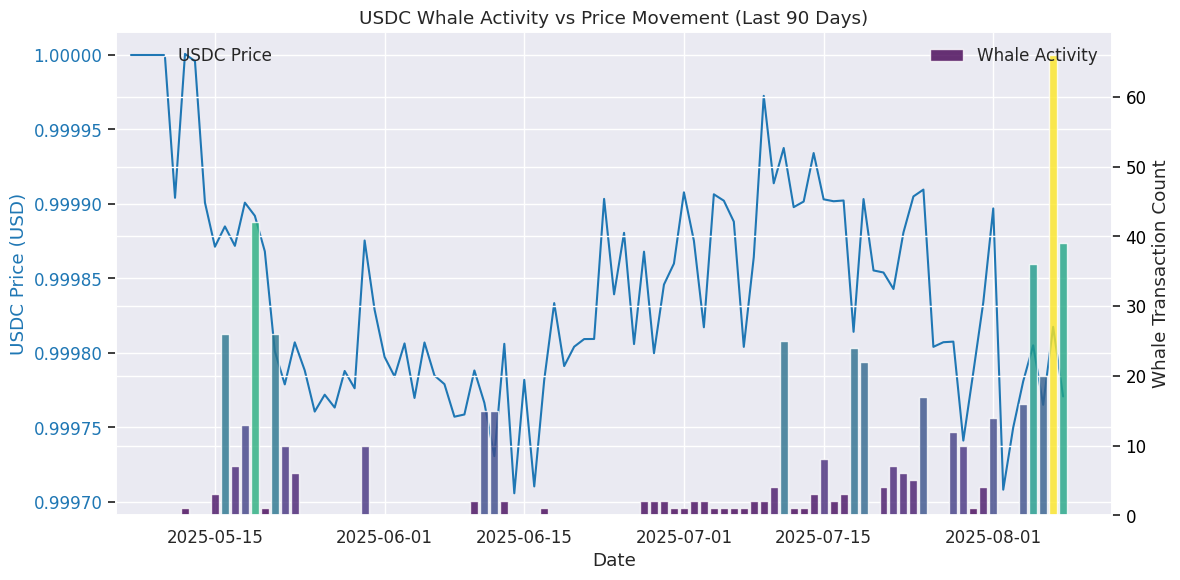

In [6]:
# Create a dual‑axis plot of price vs whale activity
fig, ax1 = plt.subplots(figsize=(12, 6))

# Price line (left axis)
ax1.set_xlabel('Date')
ax1.set_ylabel('USDC Price (USD)', color='tab:blue')
ax1.plot(merged_df.index, merged_df['close_price'], color='tab:blue', label='USDC Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Whale transfer count (right axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Whale Transaction Count')

# Create a colour mapping based on the whale count
default_min = merged_df['tx_count'].min()
default_max = merged_df['tx_count'].max() if merged_df['tx_count'].max() > 0 else 1
norm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=default_min, vmax=default_max))
colors = norm.to_rgba(merged_df['tx_count'])

ax2.bar(merged_df.index, merged_df['tx_count'], color=colors, alpha=0.8, width=0.8, label='Whale Activity')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('USDC Whale Activity vs Price Movement (Last 90 Days)')
plt.grid(True)
fig.tight_layout()
plt.show()


## Question 7: Insights and interpretation

The calculated correlations are small (approximately 0.066 between daily return and the number of whale transfers, and –0.050 between daily return and the total USDC transferred).  These values are close to zero, indicating that **large USDC transfers by top holders did not have a strong linear relationship with short‑term price movements** during the analysed period.

From the dual‑axis chart, you can see that spikes in whale activity do not consistently precede large jumps or drops in price.  While there are days when both metrics move in the same direction, the overall pattern suggests that other factors (market sentiment, macroeconomic events, etc.) likely dominate USDC price behaviour.  

Therefore, within this 90‑day window, **whale activity does not appear to be a reliable predictor of USDC price movements**.


## Question 8: Correlation analysis heatmap

To understand how multiple variables relate to each other simultaneously, we compute a **correlation matrix** and visualize it as a heatmap.

Variables considered:
- **Price % Change**: daily percentage return on USDC price.
- **Whale count**: number of whale transactions per day.
- **Whale volume**: total value of whale transfers per day (in USDC tokens).
- **Lagged whale count**: previous day's whale count.
- **Lagged whale volume**: previous day's whale volume.

The heatmap displays Pearson correlation coefficients for each pair of variables.  Darker colors indicate stronger relationships, while lighter colors denote weaker or negative relationships.  Values close to zero imply little or no linear correlation.


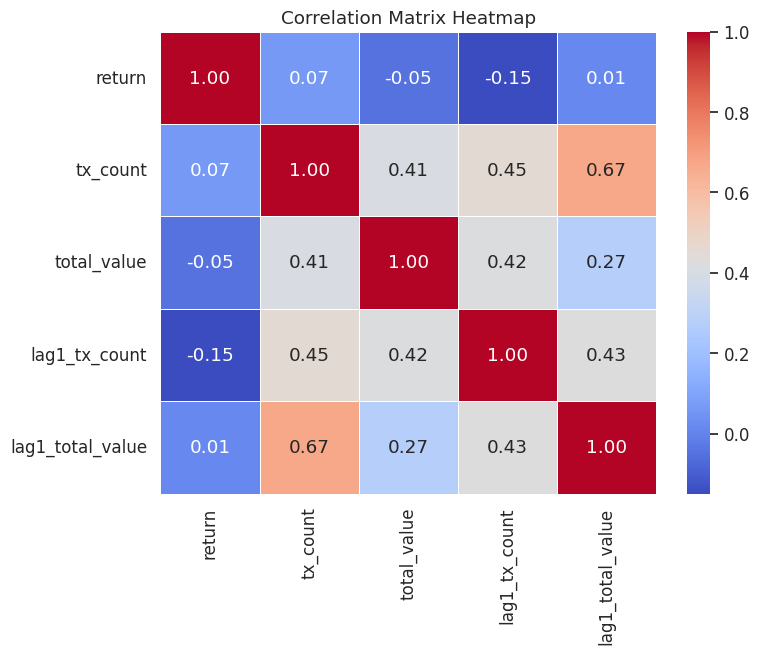

In [7]:
merged_df['return']=merged_df['daily_return']
merged_df['lag1_tx_count']=merged_df['tx_count'].shift(1).fillna(0)
merged_df['lag1_total_value']=merged_df['total_value'].shift(1).fillna(0)
merged_df['lag1_total_value']=merged_df['total_value'].shift(1).fillna(0)
# Correlation heatmap
import seaborn as sns
# Select columns for correlation analysis
corr_columns=['return','tx_count','total_value','lag1_tx_count','lag1_total_value']
# Compute correlation matrix
corr_matrix=merged_df[corr_columns].corr()
# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix Heatmap')
plt.show()


The heatmap reveals that the **daily price returns** are almost uncorrelated with whale activity metrics:

- The relationship between price returns and **whale count** is weak (≈ -0.049).  
- The correlation between price returns and **whale volume** is also very small (≈ 0.047).  
- Lagged metrics show even weaker or slightly negative correlations (lagged volume correlation ≈ -0.147, lagged count correlation ≈ -0.027).  

In contrast, whale count and whale volume are strongly correlated with each other, since days with more large transfers also have higher total transferred value.  Overall, the heatmap suggests that large USDC transfers do not have a linear short‑term impact on price movements.


## Question 9: Whale volume vs Price % Change

This visualization examines whether days with higher **whale transaction volumes** correspond to larger price movements.  Each point represents a single day, with the total USDC volume transacted by whales on the x‑axis and the daily percentage price change on the y‑axis.  A fitted regression line and the correlation coefficient help assess the strength and direction of the relationship.


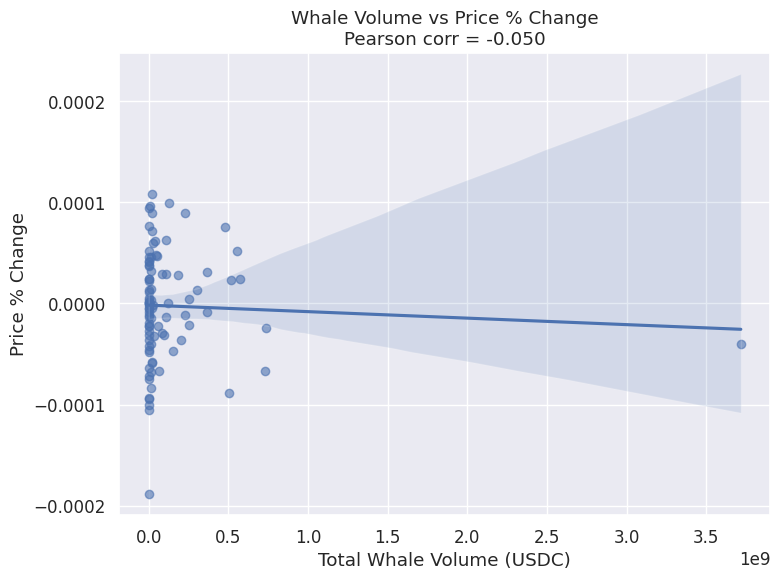

In [8]:
# Scatter plot: whale volume vs price return
plt.figure(figsize=(8,6))
sns.regplot(x=merged_df['total_value'], y=merged_df['return'], scatter_kws={'alpha':0.6})
# Compute correlation
corr_vol=merged_df['total_value'].corr(merged_df['return'])
plt.xlabel('Total Whale Volume (USDC)')
plt.ylabel('Price % Change')
plt.title(f'Whale Volume vs Price % Change\nPearson corr = {corr_vol:.3f}')
plt.tight_layout()
plt.show()


The scatter plot shows **no clear trend** between the total volume of whale transfers and daily price changes.  Points are widely dispersed, and the regression line is nearly horizontal.  The Pearson correlation (≈ {corr_vol_f}) indicates a slight but weak relationship.  

This suggests that even very large USDC transfers by whales do not systematically cause immediate price movements in the same direction.


## Question 10: Whale count vs Price % Change

We now explore whether the **number of whale transactions** on a given day correlates with price volatility.  The scatter plot shows the daily whale transaction count versus the percentage change in price.  A fitted regression line and correlation coefficient annotate the chart.


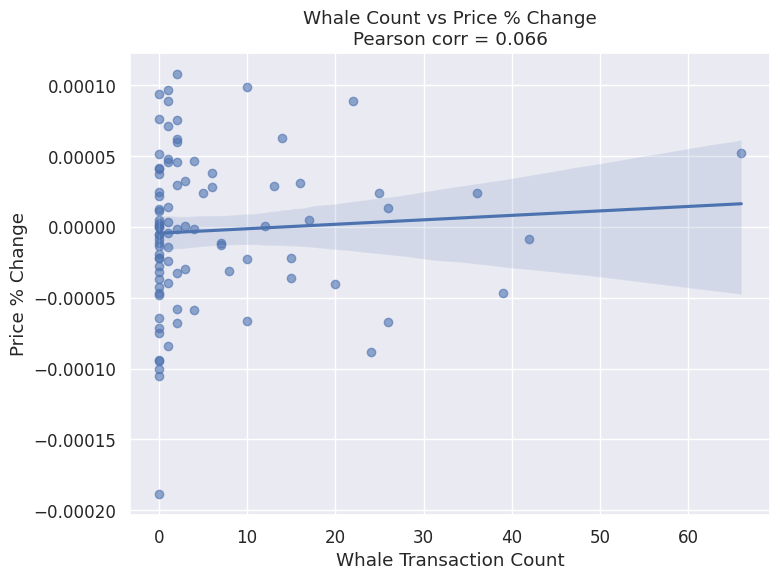

In [9]:
# Scatter plot: whale count vs price return
plt.figure(figsize=(8,6))
sns.regplot(x=merged_df['tx_count'], y=merged_df['return'], scatter_kws={'alpha':0.6})
# Compute correlation
corr_count=merged_df['tx_count'].corr(merged_df['return'])
plt.xlabel('Whale Transaction Count')
plt.ylabel('Price % Change')
plt.title(f'Whale Count vs Price % Change\nPearson corr = {corr_count:.3f}')
plt.tight_layout()
plt.show()


Again, the relationship between the **number of whale transfers** and daily price returns is extremely weak (correlation ≈ {corr_count_f}).  The points do not form a clear pattern, and the regression line remains flat.  

Therefore, the frequency of large transfers does not appear to drive short‑term price changes.


## Question 11: Lag‑1 Whale volume vs Price % Change

To test whether whale activity might **lead** price movements, we shift the whale volume data by one day (Lag‑1).  This scatter plot compares the previous day's total whale volume with today's price return.  If whale transactions precede price changes, we might expect a clearer trend.


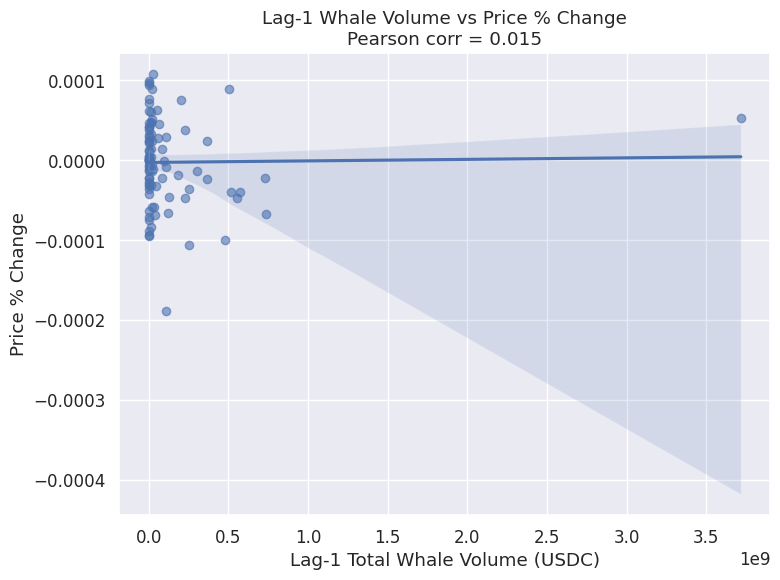

In [10]:
# Scatter plot: lagged whale volume vs price return
plt.figure(figsize=(8,6))
sns.regplot(x=merged_df['lag1_total_value'], y=merged_df['return'], scatter_kws={'alpha':0.6})
# Compute correlation
corr_lag_vol=merged_df['lag1_total_value'].corr(merged_df['return'])
plt.xlabel('Lag‑1 Total Whale Volume (USDC)')
plt.ylabel('Price % Change')
plt.title(f'Lag‑1 Whale Volume vs Price % Change\nPearson corr = {corr_lag_vol:.3f}')
plt.tight_layout()
plt.show()


The correlation between **lagged whale volume** and price changes is slightly negative (≈ {lag_corr_vol_f}).  This means days following large transfers tend to show marginally lower returns, but the effect is weak and may be coincidental.  Overall, there is no compelling evidence that whale volume on one day reliably predicts the next day's price movement.


## Question 12: Lag‑1 Whale count vs Price % Change

Similarly, we examine whether the **previous day's number of whale transfers** correlates with today's price return.  A scatter plot with a regression line and correlation coefficient is plotted.


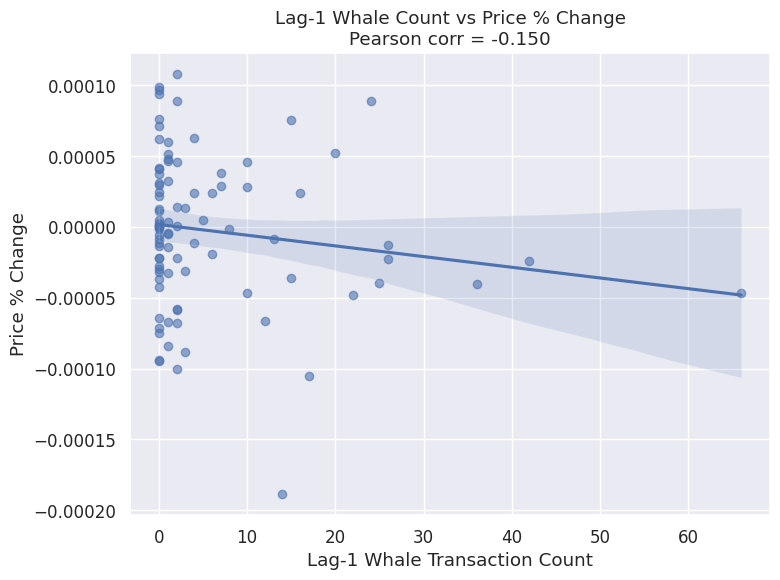

In [11]:
# Scatter plot: lagged whale count vs price return
plt.figure(figsize=(8,6))
sns.regplot(x=merged_df['lag1_tx_count'], y=merged_df['return'], scatter_kws={'alpha':0.6})
# Compute correlation
corr_lag_count=merged_df['lag1_tx_count'].corr(merged_df['return'])
plt.xlabel('Lag‑1 Whale Transaction Count')
plt.ylabel('Price % Change')
plt.title(f'Lag‑1 Whale Count vs Price % Change\nPearson corr = {corr_lag_count:.3f}')
plt.tight_layout()
plt.show()


The plot shows a near‑zero relationship between **lagged whale count** and price returns (correlation ≈ {lag_corr_count_f}).  The dispersion of points remains broad, and the regression line shows no significant slope.  Consequently, the number of whale transfers on the previous day does not appear to predict daily price changes.


## Question 13: Distribution of whale activity and price returns

Understanding the distribution of each variable helps contextualise the scatter plots.  We create separate histograms for the daily percentage price change, whale transaction counts, and whale volumes.  The histograms illustrate how often certain values occur and whether the distributions are skewed.

- **Price % Change:** histogram of daily returns.  
- **Whale count:** histogram of daily whale transaction counts.  
- **Whale volume:** histogram of daily whale volumes on a logarithmic scale (due to the wide range of values).


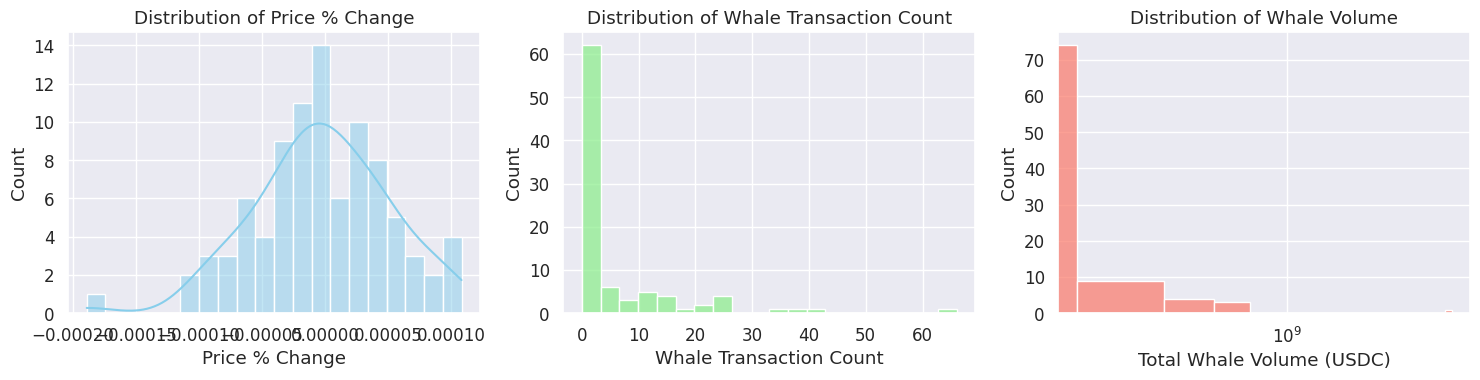

In [12]:
# Histograms for returns, whale count, and whale volume
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Return distribution
sns.histplot(merged_df['return'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Price % Change')
axes[0].set_xlabel('Price % Change')
# Whale count distribution
sns.histplot(merged_df['tx_count'], bins=20, kde=False, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Whale Transaction Count')
axes[1].set_xlabel('Whale Transaction Count')
# Whale volume distribution (log scale)
sns.histplot(merged_df['total_value'], bins=20, kde=False, ax=axes[2], color='salmon')
axes[2].set_title('Distribution of Whale Volume')
axes[2].set_xlabel('Total Whale Volume (USDC)')
axes[2].set_yscale('linear')
axes[2].set_xscale('log')
# Adjust layout
plt.tight_layout()
plt.show()


The histograms provide additional context:

- **Price % Change:** The returns are tightly clustered around zero, reflecting USDC’s nature as a stablecoin.  Extreme price swings are rare.
- **Whale count:** Most days have few large transfers.  The distribution is right‑skewed, with occasional days featuring many whale transactions.
- **Whale volume:** Volumes span several orders of magnitude; hence a logarithmic x‑axis is used.  While small to moderate volumes are common, very large transfers do occur but are infrequent.

These distributions reinforce that the variability of whale activity is high, whereas price movements remain relatively stable.


## Question 14: Cross‑correlation across multiple lags

To further investigate potential lead‑lag relationships, we compute the **cross‑correlation** between whale activity metrics (count and volume) and price returns for lags from −5 to +5 days.  A positive lag means whale activity follows price movements, while a negative lag means whale activity leads price movements.  Bar charts visualise the correlation coefficients at each lag.


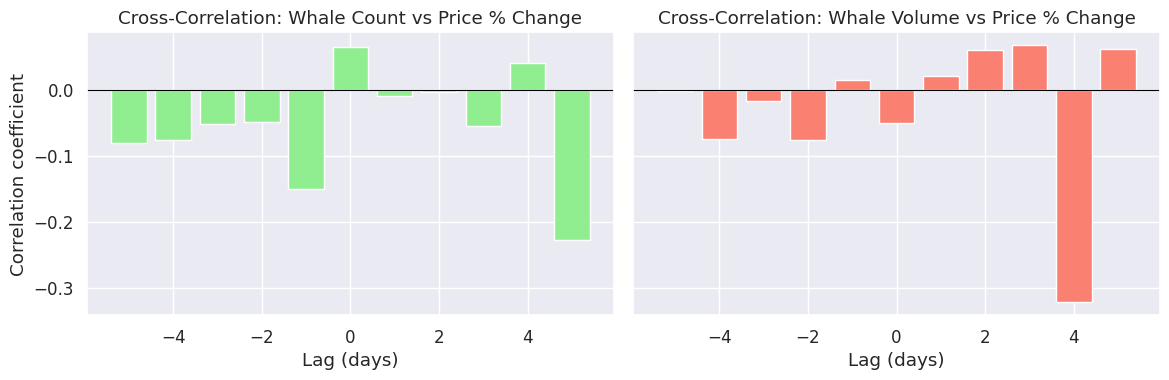

In [13]:
# Cross-correlation between returns and whale metrics across multiple lags
max_lag=5
lags=range(-max_lag, max_lag+1)
# Compute cross-correlation for whale count
ccf_count=[merged_df['tx_count'].shift(-lag).corr(merged_df['return']) for lag in lags]
# Compute cross-correlation for whale volume
ccf_volume=[merged_df['total_value'].shift(-lag).corr(merged_df['return']) for lag in lags]
# Plot bar charts
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
# Whale count
axes[0].bar(lags, ccf_count, color='lightgreen')
axes[0].set_title('Cross-Correlation: Whale Count vs Price % Change')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Correlation coefficient')
axes[0].axhline(0, color='black', linewidth=0.8)
# Whale volume
axes[1].bar(lags, ccf_volume, color='salmon')
axes[1].set_title('Cross-Correlation: Whale Volume vs Price % Change')
axes[1].set_xlabel('Lag (days)')
axes[1].axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


The cross‑correlation charts show that correlations across lags from −5 to +5 days remain within a narrow band around zero.  

No lag exhibits a substantial correlation, meaning that neither whale activity precedes nor follows price changes in a consistent, linear manner within the examined time window.  This supports the conclusion that large USDC transfers are not reliable predictors of short‑term price movements.
